# Harvest and transform

There is a considerable amount of data transform and processing, before we obtain a per-EZG, per-variable timeseries CSV.
Most of the heavy lifiting is outsources to thrid party packages wherever possible, the remainder is implemented into a `EZG` class, which represents the EZG and makes processing easy. 

The first part of this example shows how a single EZG can be accessed, the second part, how the EZG can access data. The processed data is then reduced and saved to disk.

In [1]:
import os
import json

from wetterdienst.provider.dwd import radar, observation
from datetime import datetime as dt
from datetime import timedelta as td

from harvest.ezg import EZG
from harvest.radolan import RadolanUtility
from harvest.reducers.station import transpose_station_data
from harvest.reducers.radolan import spatial_reduce

All EZGs can easily be read from a geo-spatial file. Read a ESRI Shapefile, GeoJSON, whatever is convenient for you.
It has to be a vector file and the coordinate reference system has to be defined.

In [2]:
# load all EZGs from the file
all_ezgs = EZG.from_file('./EZG/Basiseinzugsgebiet (AWGN)_polygon.shp')

Take a single one from the list, print attribute table and show the shape

OrderedDict([('OBJECTID', 206), ('OBJECT_ID', 1464.0), ('FG_ID', 1464), ('FGKZ_NR', 2472600000000.0), ('LANGNAME', 'Ohrenbach'), ('FLAECHE', 51.011), ('EINZUGSGEB', 4), ('EINZUGSG00', 'Einzugsgebiet'), ('EINZUGSG01', 'B'), ('EINZUGSG02', 'Basis-Einzugsgebiet'), ('VOR_FGKZ_N', 2472000000000.0), ('VOR_FG_ID', 4217.0), ('VOR_FG_LAN', 'Mud'), ('WASSERKOER', None), ('WASSERKO00', None), ('AENDERUNGS', '20160818'), ('AENDERUN00', '20160818'), ('LENGTH', 0.0), ('MOD_BY', 'GEO'), ('LAST_MOD', '20160818'), ('SE_ANNO_CA', None), ('WASSERKO01', None), ('FLAECHE_GE', 378.145), ('STAND_FACH', 'Mai 2021')])


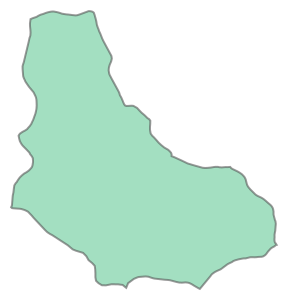

In [4]:
# use just one and download radolan data
ezg = all_ezgs[13]

print(ezg.properties)

ezg.shape

## Parameter

The next cell is using the Radolan utility to specify the request and hot-load the data. This takes a while, but it is cached for this session and the EZGs use the cache instead of re-downloading radolan data all over the place.

This is a possbile TODO, as it would be even more convenient to save the cache to disk, if the user wishes so. One has to trade-off disk-space for memory here.

In [5]:
# hot-load RADOLAN, to make stuff faster
radolan = RadolanUtility(
    parameter=radar.DwdRadarParameter.RADOLAN_CDC,
    period=radar.DwdRadarPeriod.RECENT,
    resolution=radar.DwdRadarResolution.HOURLY,
    start_date=dt.now() - td(days=30),
    end_date=dt.now()
)

# hot load
radolan._load_data()

  0%|          | 0/240 [00:00<?, ?it/s]Dircache located at /home/mirko/.cache/wetterdienst
/home/mirko/anaconda3/envs/gdal/lib/python3.10/site-packages/dateparser/utils/__init__.py:130: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = tz.localize(date_obj)
719it [00:37, 19.37it/s]                         


Now, the main loop for all requested ezgs:

In [6]:
# Some settings
OUT_DIR = './temp/'                         # output directory
name_properties = ['FG_ID', 'LANGNAME']     # properites, that should make up the folder names
if_exists = 'overwirte'                     # if folder exists, either 'skip' downlaod or 'overwrite' old folder
STATION_DISTANCE = 15                       # distance in km - if there are no stations inside the EZG, search within this distance
STATION_CLOSEST_N = 1                       # if there are no stations inside and not within DISTANCE, take the N closest stations
OMIT_QUALITY_FLAG = True                    # omit the quality flag in the station data? - set to False if not in development

# we will iterate ezgs, set it to all_ezgs if you want to iterate all
ezgs = all_ezgs[:2]

# dirty fix, cause I am too stupid
#EZG._dwd_request_params['period'] = observation.DwdObservationPeriod.RECENT
#PAR = [observation.DwdObservationDataset.TEMPERATURE_AIR, observation.DwdObservationDataset.SOLAR, observation.DwdObservationDataset.WIND]
EZG._dwd_request_params['period'] = observation.DwdObservationPeriod.HISTORICAL
EZG._dwd_request_params['resolution'] = observation.DwdObservationResolution.DAILY
PAR = [observation.DwdObservationDataset.CLIMATE_SUMMARY]

# yippie
for ezg in ezgs:
    # build the name
    name = '_'.join([str(ezg.properties[prop]) for prop in name_properties])

    # check for this folder
    if os.path.exists(os.path.join(OUT_DIR, name)):
        if if_exists == 'skip':
            continue
    else:
        os.mkdir(os.path.join(OUT_DIR, name))
    
    # --------------
    # DWD STATIONS
    for P in PAR:
        EZG._dwd_request_params['parameter'] = P
        # load DWD station data
        if not ezg.get_dwd_within_ezg().df.empty:
            stations = ezg.get_dwd_within_ezg()
        elif not ezg.get_dwd_around_centroid(STATION_DISTANCE, 'km').df.empty:
            stations = ezg.get_dwd_around_centroid(STATION_DISTANCE, 'km')
        else:
            stations = ezg.get_dwd_by_rank(STATION_CLOSEST_N)
                
        # reduce the data
        station_data = transpose_station_data(stations, variables='all', omit_quality_flag=OMIT_QUALITY_FLAG,)

        # save the data
        for param_name, df in station_data.items():
            df.to_csv(os.path.join(OUT_DIR, name, f'{param_name}.csv'), index=True)

    # --------------
    # DWD RADOLAN
    # load the chunks masked by this ezg
    radolan_chunks = ezg.dwd_radolan_load(util=radolan)
    
    # reduce
    df = spatial_reduce(radolan_chunks, targets=['sum', 'mean'], utility=radolan)
    df.to_csv(os.path.join(OUT_DIR, name, 'radolan.csv'), index=True)

    # finally add the geojson
    with open(os.path.join(OUT_DIR, name, 'ezg.geojson'), 'w') as fp:
        json.dump(ezg._geojson, fp)



Dircache located at /home/mirko/.cache/wetterdienst
parameters {'end_of_interval', 'true_local_time'} are skipped in tidy format as the date parameters are currently not converted to floats
parameters {'end_of_interval', 'true_local_time'} are skipped in tidy format as the date parameters are currently not converted to floats
parameters {'end_of_interval', 'true_local_time'} are skipped in tidy format as the date parameters are currently not converted to floats
parameters {'end_of_interval', 'true_local_time'} are skipped in tidy format as the date parameters are currently not converted to floats


In [21]:
radolan.attributes[2]['datetime']

datetime.datetime(2022, 3, 13, 12, 50)